In [1]:
import os
from os import listdir
from os.path import isfile, join
from glob import glob

import random
import numpy as np
import pandas as pd
from tqdm import tqdm 

from imgaug import augmenters as iaa
import PIL.Image as Image
import matplotlib.pyplot as plt
# %matplotlib notebook 

from IPython.core.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# %autoreload
%load_ext autoreload

In [2]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0
Num GPUs Available:  1


# Loading dataset

In [3]:
# Extracting from first dataset
metacsv_path = os.path.join('data', "covid-chestxray-dataset-metadata.csv")
df = pd.read_csv(metacsv_path, encoding='utf-8', usecols=['sex', 'age', 'finding', 'filename', 'survival'])

file_exist = []
path_list = []
for idx, row in df.iterrows():
    path_ = os.path.join('data', 'covid-chestxray-dataset', row['filename'])
    path_list.append(path_)
    if os.path.exists(path_):
        file_exist.append(True)
    else:
        file_exist.append(False)
df['filename'] = path_list
df = df[file_exist]
        
# print()
# set(df.finding)

# select only no finding, bacterial, fungal and covid-19 
df_normal1 = df[df.finding.str.contains('No Finding')]
df_normal1['label'] = ["Normal" for i in range(len(df_normal1))]

df_bact = df[df.finding.str.contains('Bacterial')]
df_bact['label'] = ["Bacterial" for i in range(len(df_bact))]

df_fung = df[df.finding.str.contains('Fungal')]
df_fung['label'] = ["Fungal" for i in range(len(df_fung))]

df_covid = df[df.finding.str.contains('COVID-19')]
df_covid['label'] = ["COVID-19" for i in range(len(df_covid))]


# Extracting from second dataset
normal_xray_path = os.path.join('data', 'train', 'NORMAL')
pneumonia_xray_path = os.path.join('data', 'train', 'PNEUMONIA')

normal_xray_imgs = glob(os.path.join(normal_xray_path, '*.jpeg'))
pneumonia_xray_imgs = glob(os.path.join(pneumonia_xray_path, '*.jpeg'))

# load normal
df_normal = pd.DataFrame(normal_xray_imgs)
df_normal['label'] = ["Normal" for i in range(len(df_normal))]
df_normal.columns = ['filename','label']
df_normal1 = df_normal1.filter(items=['filename', 'label'])
df_normal = pd.concat([df_normal, df_normal1])

# load pneumonia
df_ = pd.DataFrame(pneumonia_xray_imgs)
df_.columns = ['filename']

df_viral = df_[df_.filename.str.contains('virus')]
df_viral['label'] = ["Viral" for i in range(len(df_viral))]

# combining both bacteria into single df
df_bact_ = df_[df_.filename.str.contains('bacteria')]
df_bact_['label'] = ["Bacterial" for i in range(len(df_bact_))]
df_bact = df_bact.filter(items=['filename', 'label'])
df_bact = pd.concat([df_bact, df_bact_])

df_covid = df_covid.filter(items=['filename', 'label'])
df_normal = df_normal.sample(563, random_state=42)
df_viral = df_viral.sample(563, random_state=42)
df_bact = df_bact.sample(563, random_state=42)

# combine all into 1 big df
df = pd.concat([df_normal, df_bact, df_viral, df_covid])
df.info()

print()
print(f"Bacterial: {len(df[df.label == 'Bacterial'])}")
print(f"Normal: {len(df[df.label == 'Normal'])}")
print(f"COVID-19: {len(df[df.label == 'COVID-19'])}")
print(f"Viral: {len(df[df.label == 'Viral'])}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2252 entries, 428 to 940
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2252 non-null   object
 1   label     2252 non-null   object
dtypes: object(2)
memory usage: 52.8+ KB

Bacterial: 563
Normal: 563
COVID-19: 563
Viral: 563


# Show sample dataset

In [4]:
def resize_image(img_array, image_shape=(224, 224)):
    img = Image.fromarray(img_array)
    img = img.resize(image_shape)
    return np.array(img)

def show_images(images, title=""):
    # images = [np.array(Image.open(img).convert('L')) for img in images]
    # images = [resize_image(img) for img in images]
    fig, ax = plt.subplots(1, len(images), figsize=(15, 15), dpi=100)   
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='summer')
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()
    
def convert_images(image_paths):
    images = [np.array(Image.open(img).convert('RGB')) for img in tqdm(image_paths, total=len(image_paths))]
    images = [resize_image(img) for img in images]
    return np.array(images)

In [121]:
covid_image_arrs = convert_images(df[df.label=='COVID-19'].sample(3).filename)
normal_image_arrs = convert_images(df[df.label=='Normal'].sample(3).filename)

print(f"covid_image_arrs: {covid_image_arrs.shape}")
print(f"normal_image_arrs: {normal_image_arrs.shape}")

100%|██████████| 3/3 [00:00<00:00, 98.07it/s]

covid_image_arrs: (3, 224, 224, 3)
normal_image_arrs: (3, 224, 224, 3)


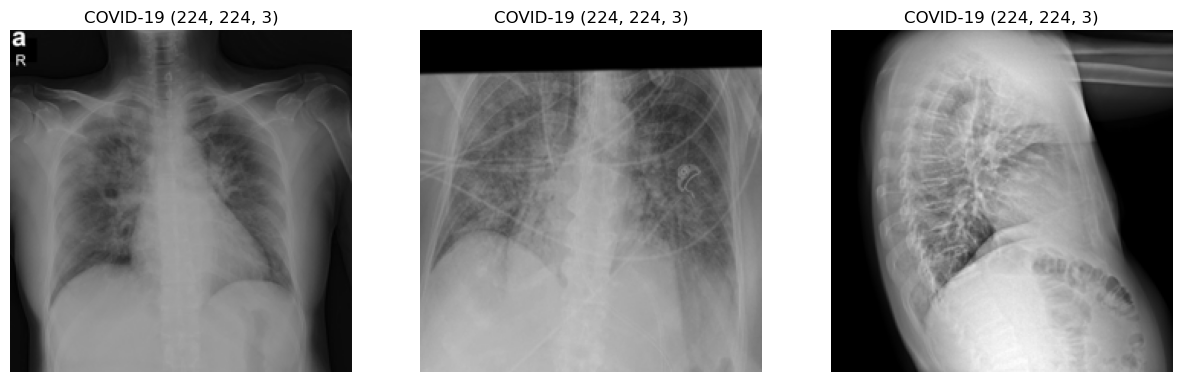

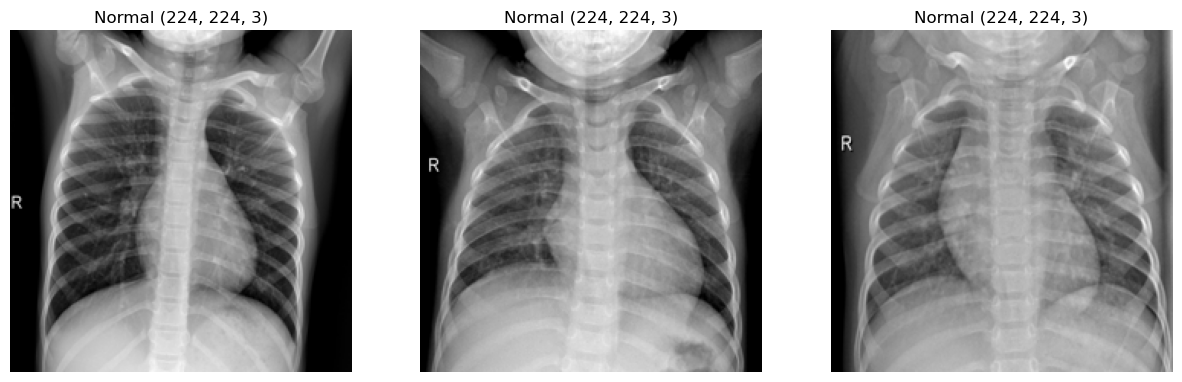

In [6]:
# Show random images that has COVID-19
show_images(random.sample(list(covid_image_arrs), 3), f"COVID-19 {covid_image_arrs[0].shape}")
show_images(random.sample(list(normal_image_arrs), 3), f"Normal {normal_image_arrs[0].shape}")

# Train / Test split (ArcFace)
<pre>
How about labels will look like
['Normal', 'Bacterial', 'Viral', 'COVID-19']

- Normal    = [1., 0., 0., 0.]
- Bacterial = [0., 1., 0., 0.]
- Vrial     = [0., 0., 1., 0.]
- COVID-19  = [0., 0., 0., 1.]
</pre>

In [5]:
from sklearn.model_selection import train_test_split

# 80:30 split on our dataset
train_size = int(len(df_normal) * 0.8)
test_size = len(df_normal) - train_size
print(f"Each category train: {train_size}, test: {test_size}")

labels = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
y_norm = [ [1., 0., 0., 0.] for i in range(len(df_normal))]
y_bact = [ [0., 1., 0., 0.] for i in range(len(df_bact))]
y_vira = [ [0., 0., 1., 0.] for i in range(len(df_viral))]
y_covi = [ [0., 0., 0., 1.] for i in range(len(df_covid))]

nX_train, nX_test, ny_train, ny_test = train_test_split(df_normal.filename, y_norm, test_size=test_size, random_state=42)
bX_train, bX_test, by_train, by_test = train_test_split(df_bact.filename, y_bact, test_size=test_size, random_state=42)
vX_train, vX_test, vy_train, vy_test = train_test_split(df_viral.filename, y_vira, test_size=test_size, random_state=42)
cX_train, cX_test, cy_train, cy_test = train_test_split(df_covid.filename, y_covi, test_size=test_size, random_state=42)

Each category train: 450, test: 113


In [6]:
df_train = pd.concat([nX_train, bX_train, vX_train, cX_train])
df_train = pd.DataFrame(df_train)
df_train['label'] = ny_train + by_train + vy_train + cy_train
df_train.columns = ['filename', 'label']
df_train.info()
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 661 to 129
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1800 non-null   object
 1   label     1800 non-null   object
dtypes: object(2)
memory usage: 42.2+ KB


,filename,label
558,data/train/NORMAL/IM-0704-0001.jpeg,"[1.0, 0.0, 0.0, 0.0]"
3000,data/train/PNEUMONIA/person398_bacteria_1799.jpeg,"[0.0, 1.0, 0.0, 0.0]"
418,data/covid-chestxray-dataset/53c9be49.jpg,"[0.0, 0.0, 0.0, 1.0]"
643,data/covid-chestxray-dataset/covid-19-caso-85-...,"[0.0, 0.0, 0.0, 1.0]"
912,data/train/NORMAL/IM-0414-0001.jpeg,"[1.0, 0.0, 0.0, 0.0]"


In [7]:
df_test = pd.concat([nX_test, bX_test, vX_test, cX_test])
df_test = pd.DataFrame(df_test)
df_test['label'] = ny_test + by_test + vy_test + cy_test
df_test.columns = ['filename', 'label']
df_test.info()
df_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452 entries, 410 to 329
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  452 non-null    object
 1   label     452 non-null    object
dtypes: object(2)
memory usage: 10.6+ KB


,filename,label
3614,data/train/PNEUMONIA/person1009_virus_1694.jpeg,"[0.0, 0.0, 1.0, 0.0]"
2485,data/train/PNEUMONIA/person862_bacteria_2784.jpeg,"[0.0, 1.0, 0.0, 0.0]"
339,data/train/NORMAL/IM-0491-0001.jpeg,"[1.0, 0.0, 0.0, 0.0]"
858,data/train/NORMAL/NORMAL2-IM-1277-0001.jpeg,"[1.0, 0.0, 0.0, 0.0]"
3530,data/train/PNEUMONIA/person689_bacteria_2586.jpeg,"[0.0, 1.0, 0.0, 0.0]"


# Creating data generator

In [8]:
import cv2

class datagenerator(object):
    def __init__(self, df_train, df_test, image_shape=(224, 224)):
        self.df_train = df_train
        self.df_test = df_test        
        self.image_shape = image_shape
        
        self.train_images = self.convert_images(df_train['filename'].tolist())
        self.test_images = self.convert_images(df_test['filename'].tolist())
    
    def resize_image(self, img_array):
        img = Image.fromarray(img_array)
        img = img.resize(self.image_shape)
        return np.array(img)

    def convert_images(self, image_paths):
        images = [np.array(Image.open(img).convert('RGB')) for img in tqdm(image_paths, total=len(image_paths))]
        images = [self.resize_image(img) for img in images]
        return np.array(images)
    
    def histogram_equalization(self, image):
        r, g, b = cv2.split(image)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        return np.stack((r, g, b), -1)

    def augment(self, image):
        # randomly process images to create more samples
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)        
        augment_seq = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)            
            ]),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ]),
            sometimes(iaa.Crop(px=(10, int(image.shape[0] * 0.2)), keep_size=True))
        ],
        random_order=True)

        image_aug = augment_seq.augment_image(image)
        return image_aug
    
    def get_batch(self, batch_size, is_augmented=False, validation=False):        
        while True:
            if validation:
                df_ = self.df_test
                image_set_ = self.test_images
            else:
                df_ = self.df_train
                image_set_ = self.train_images
                
            random_indexes = np.random.choice(len(df_), batch_size)                   
            batch_images = image_set_[random_indexes]
            batch_labels = df_.iloc[random_indexes]['label'].tolist()
            
            # preparing images
            prep_images = []
            for image in batch_images:                 
                # augment image
                if is_augmented and not validation:
                    image = self.augment(image)
                
                # image historgram equalization
                image = self.histogram_equalization(image)
                
                # image denoise
                # image = cv2.medianBlur(image, 3)
                
                # image normalization
                image = np.divide(image, 255)
                prep_images.append(image)
            
            batch_images = prep_images
                
            yield np.array(batch_images), np.array(batch_labels)


# Visualise generated images

In [107]:
generator = datagenerator(df_train, df_test)
gen_batch = generator.get_batch(10, is_augmented=False, validation=False)
batch_img, batch_label = next(gen_batch)

100%|██████████| 452/452 [00:04<00:00, 95.43it/s] 


[0. 0. 0. 1.] COVID-19
[0. 1. 0. 0.] Bacterial
[1. 0. 0. 0.] Normal
[0. 1. 0. 0.] Bacterial
[1. 0. 0. 0.] Normal


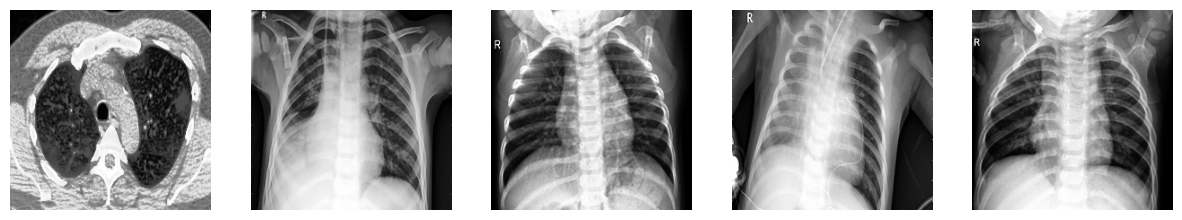

In [108]:
batch_img, batch_label = next(gen_batch)

# visualise generate images
for l in batch_label[:5]:
    print(l, labels[np.argmax(l)])
    
show_images(batch_img[:5])

# Base model

## Create base model

In [8]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback
from keras.layers import Input, Dropout, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization, Conv2D
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()

In [10]:
def create_simple_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(3, 3))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)        
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

In [ ]:
batch_size = 40

model_path = os.path.join("weights", "simple_covid19_weights.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

train_gen = generator.get_batch(batch_size, is_augmented=True, validation=False)
test_gen = generator.get_batch(400, is_augmented=False, validation=True)

In [113]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

# batch_img, _ = next(train_gen)
simple_model = create_simple_model((224,224,3), 4)
simple_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
simple_model.summary()                                                                            

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
average_pooling2d_7 (Average (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               224

## Load model

In [12]:
model_path = os.path.join("weights", "simple_covid19_weights.hd5")
simple_model = load_model(model_path)
# simple_model.summary()

## Training model

In [114]:
history = simple_model.fit_generator(
    train_gen,
    steps_per_epoch=len(df_train) // batch_size,
    validation_data=next(test_gen),
    epochs=100,
    verbose=1,
    callbacks=[reduceLROnPlato, checkPoint, earlyStop])

Epoch 1/100
45/45 [==============================] - 4s 79ms/step - loss: 1.9680 - accuracy: 0.4467 - val_loss: 1.3130 - val_accuracy: 0.4550

Epoch 00001: val_loss improved from inf to 1.31298, saving model to weights/simple_covid19_weights.hd5
INFO:tensorflow:Assets written to: weights/simple_covid19_weights.hd5/assets
Epoch 2/100
45/45 [==============================] - 3s 78ms/step - loss: 1.0077 - accuracy: 0.5667 - val_loss: 1.2634 - val_accuracy: 0.3750

Epoch 00002: val_loss improved from 1.31298 to 1.26336, saving model to weights/simple_covid19_weights.hd5
INFO:tensorflow:Assets written to: weights/simple_covid19_weights.hd5/assets
Epoch 3/100
45/45 [==============================] - 3s 76ms/step - loss: 1.0025 - accuracy: 0.5617 - val_loss: 1.4185 - val_accuracy: 0.3500

Epoch 00003: val_loss did not improve from 1.26336
Epoch 4/100
45/45 [==============================] - 3s 75ms/step - loss: 0.9842 - accuracy: 0.5628 - val_loss: 1.3190 - val_accuracy: 0.3625

Epoch 00004: 

45/45 [==============================] - 3s 75ms/step - loss: 0.6712 - accuracy: 0.7311 - val_loss: 0.6852 - val_accuracy: 0.7050

Epoch 00035: val_loss did not improve from 0.59552
Epoch 36/100
45/45 [==============================] - 3s 76ms/step - loss: 0.7301 - accuracy: 0.7117 - val_loss: 0.6561 - val_accuracy: 0.7075

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00036: val_loss did not improve from 0.59552
Epoch 00036: early stopping


## Model evaluation

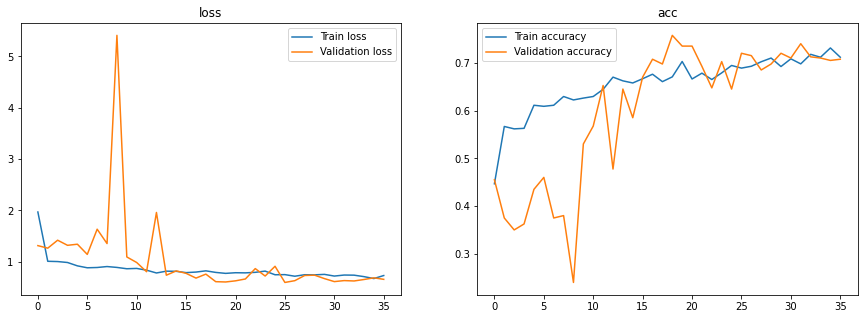

In [115]:
show_history(history)

In [119]:
from sklearn.metrics import confusion_matrix, classification_report

In [120]:
test_gen = generator.get_batch(400, is_augmented=False, validation=True)
batch_img, batch_label = next(test_gen)

predict_idxs = simple_model.predict(batch_img, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(batch_label, axis=1), predict_idxs)
print(cm)

[[94  4  0  0]
 [ 9 70 19  4]
 [21 30 44  0]
 [12  5  1 87]]


In [121]:
print(classification_report(np.argmax(batch_label, axis=1), predict_idxs, target_names=labels))

              precision    recall  f1-score   support

      Normal       0.69      0.96      0.80        98
   Bacterial       0.64      0.69      0.66       102
       Viral       0.69      0.46      0.55        95
    COVID-19       0.96      0.83      0.89       105

    accuracy                           0.74       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.75      0.74      0.73       400



# ArcFace Model

In [13]:
import cv2

class arc_datagenerator(object):
    def __init__(self, df_train, df_test, image_shape=(224, 224)):
        self.df_train = df_train
        self.df_test = df_test        
        self.image_shape = image_shape
        
        self.train_images = self.convert_images(df_train['filename'].tolist())
        self.test_images = self.convert_images(df_test['filename'].tolist())
    
    def resize_image(self, img_array):
        img = Image.fromarray(img_array)
        img = img.resize(self.image_shape)
        return np.array(img)

    def convert_images(self, image_paths):
        images = [np.array(Image.open(img).convert('RGB')) for img in tqdm(image_paths, total=len(image_paths))]
        images = [self.resize_image(img) for img in images]
        return np.array(images)
    
    def histogram_equalization(self, image):
        r, g, b = cv2.split(image)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        return np.stack((r, g, b), -1)

    def augment(self, image):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        # randomly process images to create more samples
        augment_seq = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270)            
            ]),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5)
            ]),
            sometimes(iaa.Crop(px=(10, int(image.shape[0] * 0.2)), keep_size=True))
        ],
        random_order=True)

        image_aug = augment_seq.augment_image(image)
        return image_aug
    
    def get_batch(self, batch_size, is_augmented=False, validation=False):        
        while True:
            if validation:
                df_ = self.df_test
                image_set_ = self.test_images
            else:
                df_ = self.df_train
                image_set_ = self.train_images
                
            random_indexes = np.random.choice(len(df_), batch_size)                   
            batch_images = image_set_[random_indexes]
            batch_labels = df_.iloc[random_indexes]['label'].tolist()
            
            # preparing images
            prep_images = []
            for image in batch_images:                 
                # augment image
                if is_augmented and not validation:
                    image = self.augment(image)
                
                # image historgram equalization
                image = self.histogram_equalization(image)
                
                # image denoise
                # image = cv2.medianBlur(image, 3)
                
                # image normalization
                image = np.divide(image, 255)
                prep_images.append(image)
            
            batch_images = prep_images
                
            yield [np.array(batch_images), np.array(batch_labels)], np.array(batch_labels)

100%|██████████| 452/452 [00:05<00:00, 90.12it/s] 


[0. 1. 0. 0.] Bacterial
[1. 0. 0. 0.] Normal
[0. 0. 0. 1.] COVID-19
[1. 0. 0. 0.] Normal
[0. 0. 1. 0.] Viral


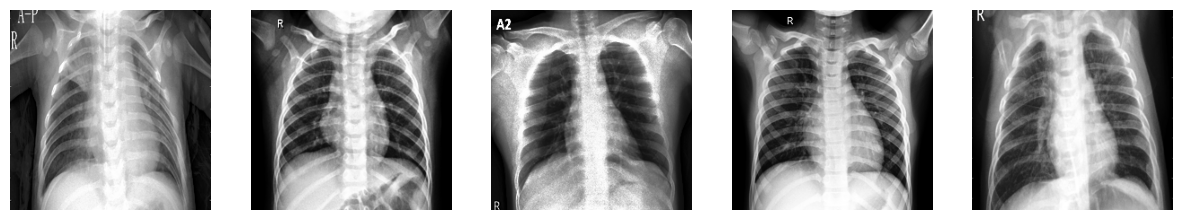

In [14]:
arc_generator = arc_datagenerator(df_train, df_test)
gen_batch = arc_generator.get_batch(5, is_augmented=False, validation=False)
(batch_img, _), batch_label = next(gen_batch)

# visualise generate images
for l in batch_label[:5]:
    print(l, labels[np.argmax(l)])
    
show_images(batch_img[:5])


## Create arcface model

In [103]:
from metrics import ArcFace, SphereFace, CosFace


# For reference
def create_simple_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(3, 3))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)
    x = Dense(n_out, activation='softmax')(x)
    
    model = Model(input_tensor, x)
    return model

# Finetune simple model by dropping for the softmax classification head
# s is a scale for logits, setting too low will cause logits to return -1 and u will usual 100% acurracy
# m is a modifier on how much it rely on softmax. setting it to 0 will cause arcface to behave as softmax
def finetune_simple_arcface_model(premodel, n_out):
    output_tensor = Input(shape=n_out)
    
    # remove classification head
    model = Sequential()
    for layer in premodel.layers[:-1]:
        model.add(layer)
    
    # freeze layer, only train layers after flatten
    for layer in model.layers[:-3]:
        layer.trainable = False
    
    # model.add(Dense(128, kernel_initializer='he_normal'))
    output = ArcFace(n_classes=n_out, s=6.0, m=2.0)([model.output, output_tensor])
    
    model = Model([model.input, output_tensor], output)
    return model

# Adding CosFace directly to simple model architecture
def create_simple_arcface_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    output_tensor = Input(shape=n_out)
    
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(64, kernel_initializer='he_normal')(x)    
    x = BatchNormalization()(x)
    output = ArcFace(n_classes=n_out, s=6.0, m=2.0)([x, output_tensor])
    
    model = Model([input_tensor, output_tensor], output)
    return model

In [104]:
batch_size = 40

model_path = os.path.join("weights", "arcface_covid19_weights.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

train_gen = arc_generator.get_batch(batch_size, is_augmented=True, validation=False)
test_gen = arc_generator.get_batch(400, is_augmented=False, validation=True)

In [105]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

#X_train, y_train = next(train_gen)
# simple_arcface_model = create_simple_arcface_model((224,224, 3), 4)

simple_arcface_model = finetune_simple_arcface_model(simple_model, 4)
simple_arcface_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'], run_eagerly=True)
simple_arcface_model.summary()                                                                            

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 222, 222, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 74, 74, 32)   0           conv2d_7[3][0]                   
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 74, 74, 32)   128         average_pooling2d_7[3][0]        
____________________________________________________________________________________________

## Training model

In [106]:
history = simple_arcface_model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // batch_size,
    validation_data=next(test_gen),
    epochs=10,
    verbose=1, 
    callbacks=[reduceLROnPlato, checkPoint, earlyStop])

Epoch 1/10
45/45 [==============================] - 4s 82ms/step - loss: 0.8485 - accuracy: 0.8122 - val_loss: 0.0099 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00991, saving model to weights/arcface_covid19_weights.hd5
INFO:tensorflow:Assets written to: weights/arcface_covid19_weights.hd5/assets
Epoch 2/10
45/45 [==============================] - 4s 85ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00991 to 0.00621, saving model to weights/arcface_covid19_weights.hd5
INFO:tensorflow:Assets written to: weights/arcface_covid19_weights.hd5/assets
Epoch 3/10
45/45 [==============================] - 3s 76ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00621 to 0.00476, saving model to weights/arcface_covid19_weights.hd5
INFO:tensorflow:Assets written to: weights/arcface_covid19_weights.hd5/assets
Epoch 4/10
45/45 [==

## Model evaluation

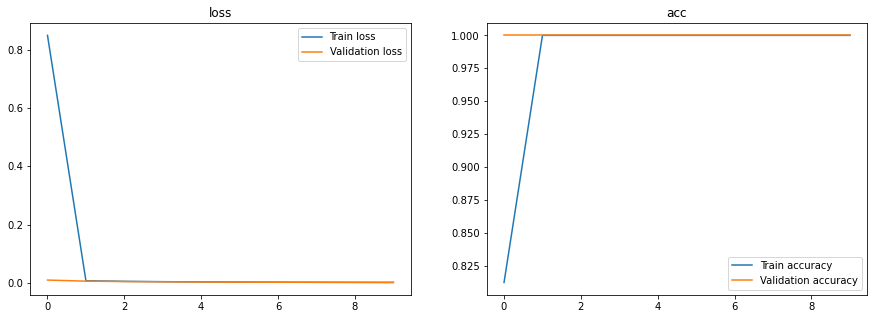

In [107]:
show_history(history)

In [108]:
from sklearn.metrics import confusion_matrix, classification_report

test_gen = arc_generator.get_batch(452, is_augmented=False, validation=True)
batch_img, batch_label = next(test_gen)

predict_idxs = simple_arcface_model.predict(batch_img, batch_size=batch_size)
predict_idxs = np.argmax(predict_idxs, axis=1)

cm = confusion_matrix(np.argmax(batch_label, axis=1), predict_idxs)
print(cm)

[[127   0   0   0]
 [  0 116   0   0]
 [  0   0  96   0]
 [  0   0   0 113]]


In [109]:
print(classification_report(np.argmax(batch_label, axis=1), predict_idxs, target_names=labels))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       127
   Bacterial       1.00      1.00      1.00       116
       Viral       1.00      1.00      1.00        96
    COVID-19       1.00      1.00      1.00       113

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452



## load model

In [119]:
simple_arcface_model = load_model(model_path)
simple_arcface_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 222, 222, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 74, 74, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 74, 74, 32)   128         average_pooling2d_7[0][0]        
____________________________________________________________________________________________

# Visualise model

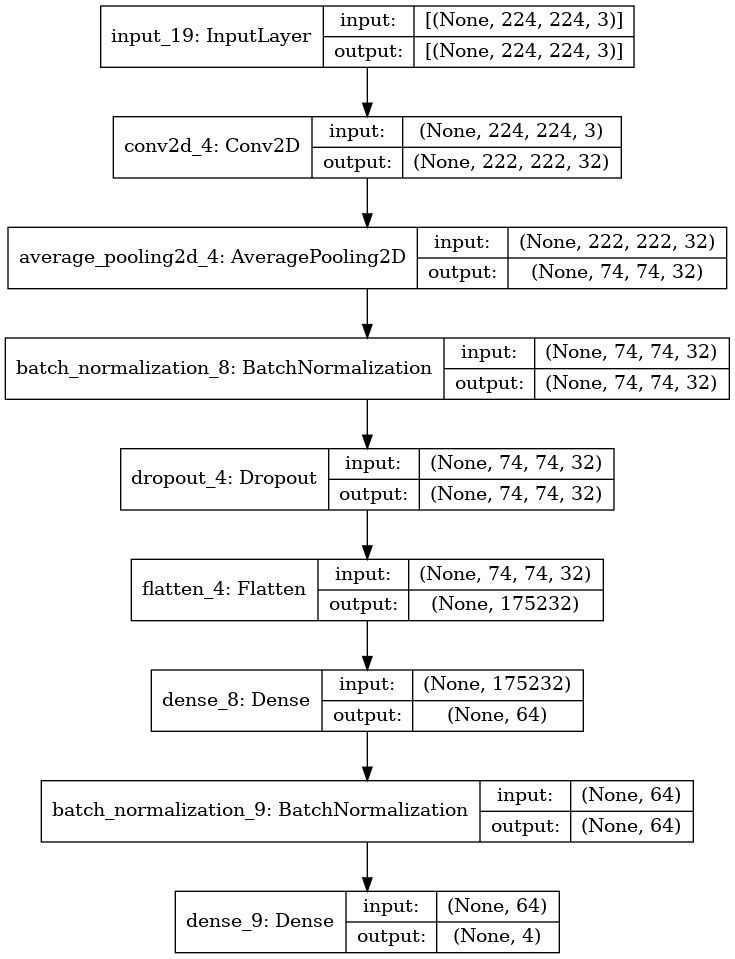

In [11]:
tf.keras.utils.plot_model(
    simple_model,
    to_file="simple_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

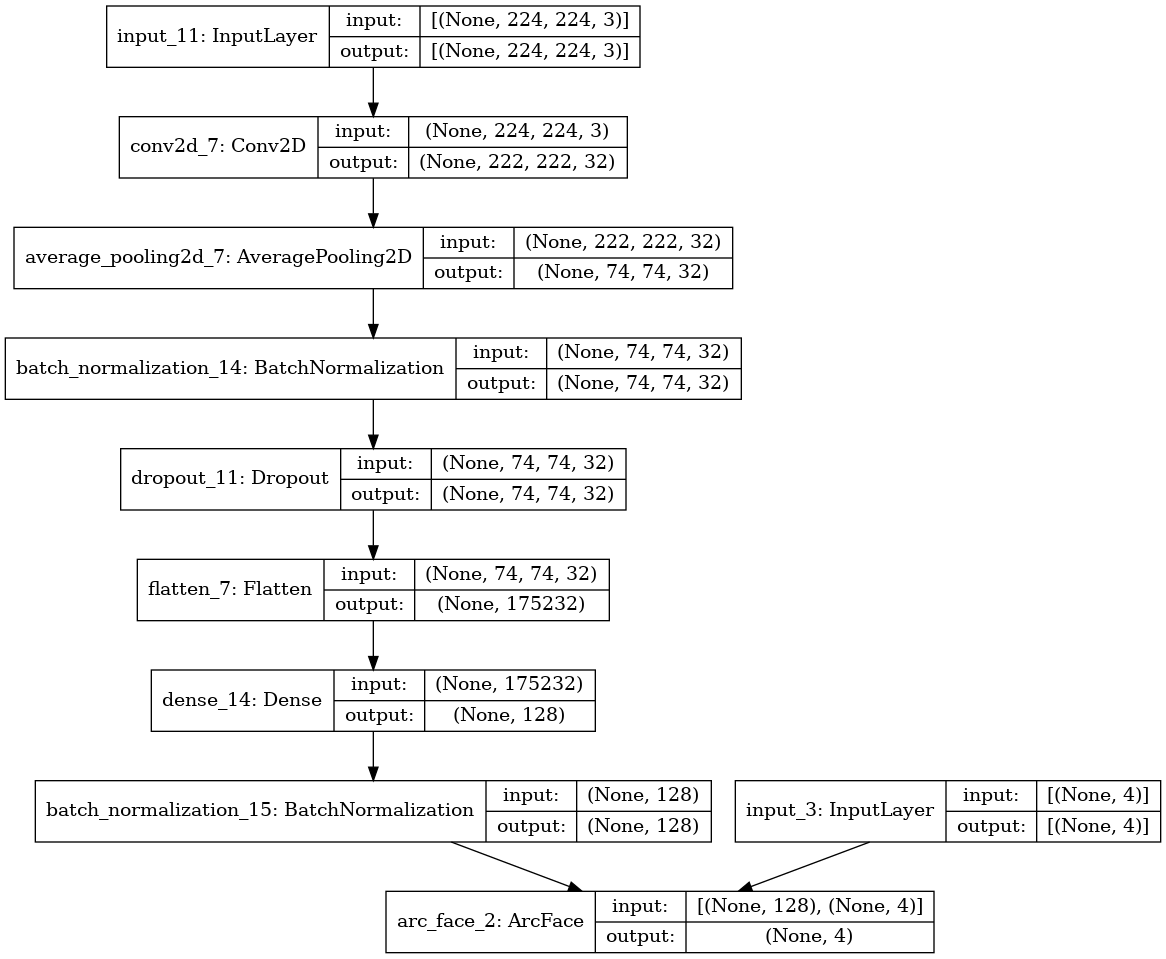

In [110]:
tf.keras.utils.plot_model(
    simple_arcface_model,
    to_file="simple_arcface_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

# Visualise embedding

In [111]:
def embedding_simple_arcface_model(arcface_model):    
    # remove classification head
    model = Sequential()
    for layer in arcface_model.layers[:-2]:
        model.add(layer)        
    return model

In [112]:
embed_arcface_model = embedding_simple_arcface_model(simple_arcface_model)
embed_arcface_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
average_pooling2d_7 (Average (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 74, 74, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               22429824  
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)              

In [113]:
gen_batch = arc_generator.get_batch(450, is_augmented=False, validation=True)
(batch_img, _), batch_label = next(gen_batch)

In [114]:
label_dict = {
    0: 'Normal',
    1: 'Baterial',
    2: 'Virus',
    3: 'COVID-19'
}
batch_label = [label_dict[np.argmax(label)] for label in batch_label]
batch_label = np.array(batch_label)
batch_label

array(['Virus', 'Normal', 'COVID-19', 'COVID-19', 'Normal', 'Baterial',
       'Baterial', 'Normal', 'Baterial', 'Normal', 'COVID-19', 'COVID-19',
       'Baterial', 'Baterial', 'Normal', 'COVID-19', 'COVID-19',
       'COVID-19', 'Normal', 'COVID-19', 'Baterial', 'Virus', 'Normal',
       'COVID-19', 'Normal', 'Virus', 'Baterial', 'COVID-19', 'Baterial',
       'Virus', 'Normal', 'COVID-19', 'Baterial', 'COVID-19', 'Baterial',
       'Virus', 'Baterial', 'Normal', 'Normal', 'Normal', 'Baterial',
       'Baterial', 'Normal', 'Baterial', 'COVID-19', 'Virus', 'Normal',
       'Normal', 'COVID-19', 'Baterial', 'Normal', 'COVID-19', 'Baterial',
       'Baterial', 'Normal', 'COVID-19', 'Virus', 'COVID-19', 'Virus',
       'Virus', 'COVID-19', 'Baterial', 'COVID-19', 'COVID-19',
       'COVID-19', 'Baterial', 'Baterial', 'COVID-19', 'Virus', 'Virus',
       'Virus', 'COVID-19', 'Normal', 'Baterial', 'Virus', 'Normal',
       'COVID-19', 'Virus', 'COVID-19', 'Virus', 'Normal', 'Virus',
      

In [115]:
embeddings = embed_arcface_model.predict(batch_img)
embeddings.shape

(450, 128)

In [116]:
import umap
import umap.plot

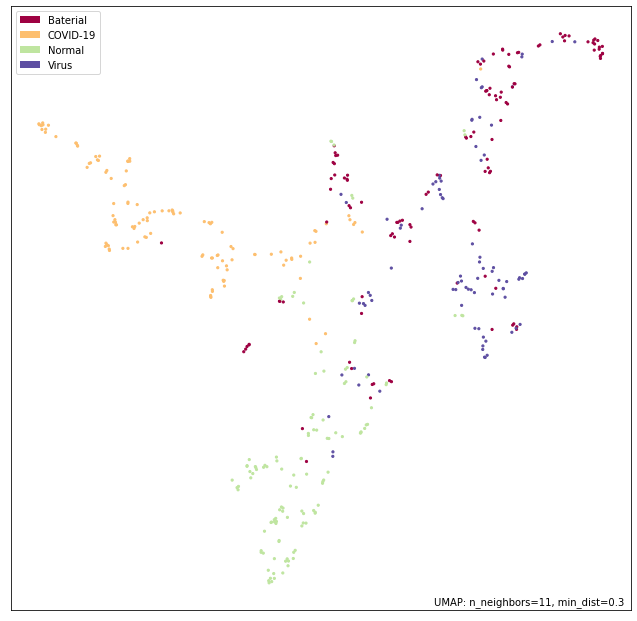

In [129]:
mapper = umap.UMAP(n_neighbors=11, min_dist=0.3, metric='euclidean').fit(embeddings)
umap.plot.points(mapper, labels=batch_label)

# Debugging keras

import sys
from metrics import ArcFace, SphereFace, CosFace
from importlib import reload
reload(sys.modules['metrics'])

In [29]:
from metrics import ArcFace, SphereFace, CosFace
%aimport metrics

def finetune_simple_arcface_model(premodel, n_out):
    output_tensor = Input(shape=n_out)
    
    # remove classification head
    model = Sequential()
    for layer in premodel.layers[:-1]:
        model.add(layer)
    
    # freeze layer, only train layers after flatten
    for layer in model.layers[:-3]:
        layer.trainable = False
    
    output = ArcFace(n_classes=n_out, s=6.0, m=2.0)([premodel.output, output_tensor])
    
    model = Model([premodel.input, output_tensor], output)
    return model

In [30]:
batch_size = 40

model_path = os.path.join("weights", "debug_arcface_covid19_weights.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

train_gen = arc_generator.get_batch(batch_size, is_augmented=True, validation=False)
test_gen = arc_generator.get_batch(400, is_augmented=False, validation=True)

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

simple_arcface_model = finetune_simple_arcface_model(simple_model, 4)
simple_arcface_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'], run_eagerly=True)
simple_arcface_model.summary()                                                                            

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 222, 222, 32) 896         input_19[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 74, 74, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 74, 74, 32)   128         average_pooling2d_4[0][0]        
______________________________________________________________________________________________

In [32]:
history = simple_arcface_model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // batch_size,
    validation_data=next(test_gen),
    epochs=1,
    verbose=1, 
    callbacks=[reduceLROnPlato, checkPoint, earlyStop])

 [[0.00548262661 0.000111292182 0.993515134 0.000890997]
 [0.006878132 0.000800945156 0.421095937 0.571224928]
 [0.00026621265 0.869417906 0.0363556333 0.0939602107]
 ...
 [0.0106389513 0.000533048587 0.631337583 0.357490391]
 [0.0314135514 0.0016244814 0.846126139 0.120835856]
 [2.91594042e-05 0.96445024 0.0192078203 0.0163126942]]
 1/45 [..............................] - ETA: 58s - loss: 7.7678 - accuracy: 0.0000e+00 [[0.0304836724 0.0015798473 0.823791265 0.144145161]
 [0.00667278934 0.000878522929 0.41656366 0.575885]
 [0.026700316 0.0018357354 0.848049045 0.123414867]
 ...
 [0.000277356 0.0125360396 0.986811459 0.00037519398]
 [0.000683467893 0.970143318 3.80250967e-05 0.0291351937]
 [0.011361015 0.000454679423 0.735355198 0.252829105]]
 [[0.0293083396 0.00152706774 0.801335514 0.167828992]
 [3.78237492e-05 0.221967712 0.776229203 0.00176526711]
 [0.00709611 0.000920990307 0.469630808 0.522352159]
 ...
 [0.130285501 0.839172065 6.23407905e-05 0.0304800496]
 [0.000292351586 0.86866

40/45 [=========================>....] - ETA: 0s - loss: 4.7776 - accuracy: 0.1100 [[0.0791416541 0.015266493 0.123969316 0.781622589]
 [0.814668477 0.0877435356 0.0517566875 0.0458312668]
 [0.541496396 0.012283776 0.0704069957 0.375812888]
 ...
 [0.010200128 0.00110414333 0.388761401 0.59993434]
 [0.010246871 0.00110363506 0.387740403 0.600909]
 [0.814668477 0.087743625 0.0517566688 0.0458312668]]
41/45 [==========================>...] - ETA: 0s - loss: 4.7294 - accuracy: 0.1134 [[0.0190263223 0.236877888 0.742902756 0.00119312119]
 [0.380835891 0.309890687 0.039689336 0.26958406]
 [0.00996531 0.001128415 0.389092624 0.599813581]
 ...
 [0.0167383123 0.00282887649 0.978877246 0.00155556458]
 [0.801950395 0.090809375 0.0569510795 0.0502890497]
 [0.0190266557 0.236889884 0.742890298 0.00119313877]]
42/45 [===========================>..] - ETA: 0s - loss: 4.6774 - accuracy: 0.1161 [[0.0178177543 0.263706595 0.717231333 0.00124424952]
 [0.00971051 0.00115571835 0.390781611 0.598352194]
 [0

# Save as html

In [130]:
!jupyter nbconvert COVID19_ArcFace_SelfSupervised.ipynb --to html

[NbConvertApp] Converting notebook COVID19_ArcFace_SelfSupervised.ipynb to html
[NbConvertApp] Writing 1977376 bytes to COVID19_ArcFace_SelfSupervised.html
